In [1]:
import pickle
import numpy as np
import os
import torch

wton = dict()
lton = dict()
ntow = dict()
ntol = dict()


def readpgm(name):    # 读取图片
    with open(name) as f:
        lines = f.readlines()

    # Ignores commented lines
    for l in list(lines):
        if l[0] == '#':
            lines.remove(l)

    # Makes sure it is ASCII format (P2)
    assert lines[0].strip() == 'P2'

    # Converts data to a list of integers
    data = []
    for line in lines[1:]:
        data.extend([int(c) for c in line.split()])   # 读取数据

    return (data[3:], (data[1],data[0]), data[2])


def get_dataset(path):
    dirs = os.listdir(path)
    imgs = []
    whos = []
    looks = []
    with open(path + '/.anonr', 'r') as f:
        i = 0
        for line in f.readlines():
            line = line[:-1]
            wton[line] = i
            ntow[i] = line
            i += 1

    look_index = 0
    for d in dirs:
        if os.path.isdir(path + '/' + d):
            for img in os.listdir(path + '/' + d):
                if img[-5].isalpha():
                    data = readpgm(path + '/' + d + '/' + img)
                    imgs.append(data[0])
                    chars = img.split('_')
                    whos.append(wton[chars[0]])
                    look = chars[-3] + '_' + chars[-2] + '_' + chars[-1].split('.')[0]
                    if look not in lton.keys():
                        lton[look] = look_index
                        ntol[look_index] = look
                        look_index += 1

                    looks.append(lton[look])

    train_index = int(len(imgs) * 0.9)
    # index = torch.randperm(torch.range(0, len(imgs)).size(0))
    imgs = torch.tensor(imgs, dtype=torch.float32)
    whos = torch.tensor(whos)
    looks = torch.tensor(looks)

    index = torch.randperm(imgs.size(0))
    train_imgs = torch.index_select(imgs, 0, index[:train_index])
    train_whos = torch.index_select(whos, 0, index[:train_index])
    train_looks = torch.index_select(looks, 0, index[:train_index])

    test_imgs = torch.index_select(imgs, 0, index[train_index:])
    test_whos = torch.index_select(whos, 0, index[train_index:])
    test_looks = torch.index_select(looks, 0, index[train_index:])

    train_set = (train_imgs, train_whos, train_looks)
    test_set = (test_imgs, test_whos, test_looks)

    return train_set, test_set, wton, lton, ntow, ntol

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim


class Model(nn.Module):
    def __init__(self, input, layer_hid=(1024, 512, 256, 20)):
        super(Model, self).__init__()
        self.mlp = nn.Sequential()
        for i, output in enumerate(layer_hid):
            if i == 0:
                self.mlp.add_module(f"{i}", nn.Linear(input, output))
            else:
                self.mlp.add_module(f"{i}", nn.Linear(layer_hid[i-1], output))

    def forward(self, X):
        output = X
        for layer in self.mlp:
            output = layer(output)
        return output

    def validate(self, X, Y):
        pred = torch.argmax(self(X), axis=1)
        true_len = sum(pred == Y)
        acc = true_len / len(pred)
        return acc

if __name__ == "__main__":
    model = Model(15360)
    # model2 = Model(170, [256])
    betas = [0.9, 0.998]
    params_emb = [p for p in model.parameters() if p.requires_grad]
    # params_emb2 = [p for p in model2.parameters() if p.requires_grad]
    # params_emb.extend(params_emb2)
    optimizer = optim.Adam(params_emb, lr=0.01, betas=betas, eps=1e-9)

    loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')
    train_set, test_set, wton, lton, ntow, ntol = get_dataset('dataset/faces')
    for epoch in range(100):
        model.train()

        X_train = train_set[0]
        Y_train = train_set[1]

        batch_size = 32
        steps = len(X_train) // batch_size

        for i in range(steps):
            indexs = torch.arange(len(X_train))
            ind = indexs[i*batch_size:(i+1)*batch_size]
            x = X_train[ind]
            y = Y_train[ind]
            optimizer.zero_grad()
            # with torch.no_grad():
            #     tmp = model2(x)
            output = model(x)
            loss = loss_fn(output, y)

            loss.backward()
            optimizer.step()

        print(model.validate(test_set[0], test_set[1]))

tensor(0.1094)
tensor(0.3281)
tensor(0.5312)
tensor(0.7812)
tensor(0.9375)
tensor(0.8438)
tensor(0.9688)
tensor(0.9531)
tensor(0.9688)
tensor(0.9688)
tensor(0.9844)
tensor(0.9688)
tensor(0.9531)
tensor(0.9531)
tensor(0.9375)
tensor(0.9844)
tensor(0.8750)
tensor(0.9688)
tensor(0.8906)
tensor(0.9375)
tensor(0.9688)
tensor(0.8438)
tensor(0.9531)
tensor(0.5469)
tensor(0.4062)
tensor(0.1094)
tensor(0.3281)
tensor(0.8438)
tensor(0.8750)
tensor(0.9219)
tensor(0.8594)
tensor(0.9062)
tensor(0.9219)
tensor(0.9844)
tensor(0.9531)
tensor(0.9219)
tensor(0.9844)
tensor(0.7500)
tensor(0.9375)
tensor(0.9531)
tensor(0.9062)
tensor(0.9375)
tensor(0.9844)
tensor(0.7656)
tensor(0.7344)
tensor(0.7031)
tensor(0.8906)
tensor(0.9844)
tensor(0.9219)
tensor(0.9844)
tensor(0.9844)
tensor(0.9844)
tensor(0.9844)
tensor(0.9531)
tensor(0.9688)
tensor(0.9844)
tensor(0.9531)
tensor(0.9688)
tensor(0.9219)
tensor(0.9844)
tensor(0.9688)
tensor(0.9062)
tensor(0.9688)
tensor(0.9375)
tensor(0.9844)
tensor(0.9844)
tensor(0.9

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(Y_test, pred):
    cm = confusion_matrix(Y_test, pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, cbar= False, ax = ax);
    plt.title('Train Confusion Matrix')
    plt.xlabel('Predicted Value')
    plt.ylabel('True Value')
    plt.show()
    plt.figure()
    plt.show()
    print('Classification report: \n',classification_report(Y_test, pred))
    print('TN - True Negative :{}'.format(cm[0,0]))
    print('FP - False Positive :{}'.format(cm[0,1]))
    print('FN - False Negative :{}'.format(cm[1,0]))
    print('TP - True Positive :{}'.format(cm[1,1]))
    print('Accuracy Rate: {}'.format(np.divide(np.sum([cm[0,0],cm[1,1]]),np.
    sum(cm))))
    print('Misclassification Rate: {}'.format(np.divide(np.sum([cm[0,1],cm[1
    ,0]]),np.sum(cm))))
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    Precision = TP/(TP+FP)
    Fscore = 2*TP/(2*TP+FP+FN)

    print('True Negative Rate:', TNR)
    print('True Positive Rate:', TPR)
    print('Precision:', Precision)
    print('F-score:', Fscore)

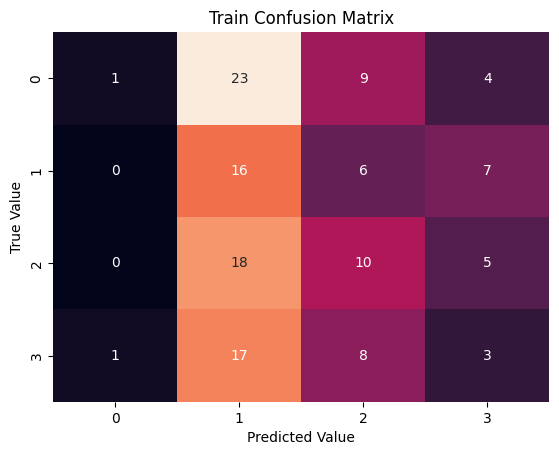

<Figure size 640x480 with 0 Axes>

Classification report: 
               precision    recall  f1-score   support

           0       0.50      0.03      0.05        37
           1       0.22      0.55      0.31        29
           2       0.30      0.30      0.30        33
           3       0.16      0.10      0.12        29

    accuracy                           0.23       128
   macro avg       0.29      0.25      0.20       128
weighted avg       0.31      0.23      0.19       128

TN - True Negative :1
FP - False Positive :23
FN - False Negative :0
TP - True Positive :16
Accuracy Rate: 0.1328125
Misclassification Rate: 0.1796875
True Negative Rate: 0.041666666666666664
True Positive Rate: 1.0
Precision: 0.41025641025641024
F-score: 0.5818181818181818
              precision    recall  f1-score   support

       angry       0.03      0.50      0.05         2
       happy       0.55      0.22      0.31        74
     neutral       0.30      0.30      0.30        33
         sad       0.10      0.16      0.12     

In [7]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

BASE_DIR= "dataset/faces"
LENGTH = 120
WIDTH = 128
NUM_CLASSES = 4

def readpgm(name):
    with open(name) as f:
        lines = f.readlines()

    for l in list(lines):
        if l[0] == '#':
            lines.remove(l)

    assert lines[0].strip() == 'P2'

    data = []
    for line in lines[1:]:
        data.extend([int(c) for c in line.split()])

    return (np.array(data[3:]),(data[1],data[0]),data[2])


def read_data():
    X = []
    labels_index = {}
    y = []
    for dir_name in sorted(os.listdir(BASE_DIR)):
        path = os.path.join(BASE_DIR, dir_name)
        if os.path.isdir(path):
            for fname in sorted(os.listdir(path)):
                if not fname.endswith("_2.pgm") and not fname.endswith("_4.pgm"):
                    emoij = {
                        "angry": 0,
                        "happy": 1,
                        "neutral": 2,
                        "sad": 3
                    }
                    fpath = os.path.join(path, fname)
                    data = readpgm(fpath)
                    if data[1]==(LENGTH, WIDTH):
                        X.append(data[0])
                        str = fname.split("_")[2]
                        y.append(emoij[str])
    return X, y

if __name__ == '__main__':
    X, y = read_data()
    X_data = np.array(X)
    y_data = np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=1)
    # clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=1)
    # clf = SGDClassifier(loss='hinge')
    # clf = SVC(kernel= 'linear', random_state=1, C=0.01)
    clf = RandomForestClassifier(n_estimators=10, max_depth=1, random_state=33)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    plot_confusion_matrix(y_test, y_pred)
    print(classification_report(y_pred, y_test, target_names=["angry", "happy", "neutral", "sad"]))